In [2]:
import pdfplumber
from konlpy.tag import Okt
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from matplotlib import font_manager, rc
import glob
import re
from gensim.models import Word2Vec

okt = Okt()

In [13]:
class internal_data():
    def __init__(self):
        pass

    def get_candidate_page_data(self,num):
        path = f'/Users/junho/Downloads/open/기호_{num} 공약.pdf'
        pdf = pdfplumber.open(path)
        temp = [page.extract_text() for page in pdf.pages]
        return temp

    def tokenization(slef,pdf):
        stopword_path = '/Users/junho/Desktop/pycharmProjects/pythonProject/dacon/visualization/data/stopwords_all.txt'
        temp = []
        f = open(stopword_path, 'r')
        stop = f.readlines()
        f.close()
        stopwords = set(i.rstrip('\n') for i in stop)
        for page in pdf.pages:
            temp.extend(okt.nouns(page.extract_text()))
        token = []
        for word in temp:
            if word not in stopwords:
                token.append(word)
        return token

    # append [[],[]..] for each candidate
    # extend [] for all
    def dict_data(self,num_of_candidate,method):
        candidate_text = []
        for num in range(1,num_of_candidate+1):
            path = f'/Users/junho/Downloads/open/기호_{num} 공약.pdf' # glob 이용 해보기
            pdf = pdfplumber.open(path)
            if method == 'each':
                candidate_text.append(self.tokenization(pdf))
            elif method == 'all':
                candidate_text.extend(self.tokenization(pdf))
        return candidate_text

    # 호출형식 pdf.pages[0].extract_text()
    # type(okt.nouns(pdf.pages[0].extract_text())) : list
    # input : pdfplumber.open(path)
    # 필요사항 : non_data dict -> 파파고

    def word_idx_dict_all(self,num_of_candidate):
        df = pd.DataFrame(data=self.dict_data(num_of_candidate,'all'))
        token_set = df.value_counts()
        word_idx = {token_set.index[i][0]: i+1 for i in range(len(token_set))}
        return word_idx

    def idx_word_dict_all(self,num_of_candidate):
        df = pd.DataFrame(data=self.dict_data(num_of_candidate, 'all'))
        token_set = df.value_counts()  # : series
        word_idx = {i+1: token_set.index[i][0] for i in range(len(token_set))}
        return word_idx

    def idx_word_dict_each(self,num_of_candidate):
        idx_word_each = []
        for i in self.dict_data(num_of_candidate, 'each'):
            temp_df = pd.DataFrame(data=i)
            token_set = temp_df.value_counts()  # 여기 까지 진행시, 빈도수 나열
            temp_word_idx = {i+1: token_set.index[i][0] for i in range(len(token_set))}
            idx_word_each.append(temp_word_idx)
        return idx_word_each

    def word_idx_dict_each(self,num_of_candidate):
        word_idx_each = []
        for i in self.dict_data(num_of_candidate, 'each'):
            temp_df = pd.DataFrame(data=i)
            token_set = temp_df.value_counts()  # 여기 까지 진행시, 빈도수 나열
            temp_word_idx = {token_set.index[i][0]:i+1 for i in range(len(token_set))}
            word_idx_each.append(temp_word_idx)
        return word_idx_each

    def showWordCloud(self,text_counts, person=None):
        tags = text_counts.most_common(100)

        wc = WordCloud(font_path='AppleGothic', background_color='white',
                       max_font_size=60)
        cloud = wc.generate_from_frequencies(dict(tags))

        plt.figure(figsize=(10, 8))
        plt.title(f'{person} keywords', size=20)
        plt.axis('off')
        plt.imshow(cloud)

    def showGraph(self,tags, person=None):
        # font_location = '/Users/junho/Downloads/나눔고딕/NanumGothic.ttf'
        # font_name = font_manager.FontProperties(fname=font_location).get_name()
        rc('font', family='AppleGothic')
        plt.rcParams['axes.unicode_minus'] = False  # 한글화 경우, 마이너스 깨짐 방지.

        plt.figure(figsize=(10, 5))
        plt.xlabel('keyword')
        plt.grid(True)

        Dict_Values = tags.values() # collection/Counter/values
        Dict_Keys = tags

        plt.title(f'{person} keyword top 20', size=20)
        plt.bar(range(len(tags)), Dict_Values, align='center')
        plt.xticks(range(len(tags)), list(Dict_Keys), rotation='70')

    def make_clear_sentences(self,candidate_number, stopword_path, drop_len=5):
        temp = self.get_candidate_page_data(candidate_number)  # input : number of candidate
        clear = [i.split('\n') for i in temp]
        hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
        clear_cen = []
        for candidate in clear:
            for cen in candidate:
                clear_cen.append(hangul.sub('', str(cen)))
        temp = [i.strip() for i in clear_cen]
        cen = []
        for i in temp:
            if len(i) > drop_len:
                cen.append(i)
        f = open(stopword_path, 'r')
        stop = f.readlines()
        f.close()
        stopwords = set(i.rstrip('\n') for i in stop)
        sents = [list(okt.nouns(i)) for i in cen]  # 원본

        sents_clear = []
        for sent in sents:
            temp = []
            for word in sent:
                if word not in stopwords:
                    temp.append(word)
            sents_clear.append(temp)
        return sents_clear

    def show_simirality(self, sents_clear, target_word, num=None):
        model = Word2Vec(sents_clear)
        df = pd.DataFrame(reversed(model.wv.most_similar(target_word)))
        df.set_index(0)

        plt.figure(figsize=(10, 6))
        plt.barh(df[0], df[1])
        plt.xlabel('Similarity')
        plt.ylabel('Words')
        if not num:
            plt.title(f"'{target_word}'의 언어 유사도")
        else:
            plt.title(f"기호{num}번의 '{target_word}' 유사도")


cl = internal_data()

In [20]:
show_each = cl.dict_data(14,'each')
show_all = cl.dict_data(14,'all')
len(show_all)

26045

In [5]:
word_idx = cl.word_idx_dict_all(14)
word_idx

{'확대': 1,
 '지원': 2,
 '국가': 3,
 '보장': 4,
 '기호': 5,
 '도입': 6,
 '법': 7,
 '제도': 8,
 '사회': 9,
 '강화': 10,
 '주택': 11,
 '국민': 12,
 '청년': 13,
 '폐지': 14,
 '추진': 15,
 '방안': 16,
 '전환': 17,
 '정책': 18,
 '제정': 19,
 '산업': 20,
 '기업': 21,
 '구축': 22,
 '교육': 23,
 '실현': 24,
 '예산': 25,
 '정부': 26,
 '마련': 27,
 '일자리': 28,
 '개정': 29,
 '지역': 30,
 '세': 31,
 '고용': 32,
 '정치': 33,
 '확보': 34,
 '통합': 35,
 '소득': 36,
 '위원회': 37,
 '금지': 38,
 '경제': 39,
 '개혁': 40,
 '시행': 41,
 '재정': 42,
 '체계': 43,
 '서비스': 44,
 '권리': 45,
 '대학': 46,
 '공급': 47,
 '지급': 48,
 '노동': 49,
 '의료': 50,
 '토지': 51,
 '문화': 52,
 '개선': 53,
 '디지털': 54,
 '미래': 55,
 '활용': 56,
 '운영': 57,
 '한반도': 58,
 '선거': 59,
 '플랫폼': 60,
 '혁신': 61,
 '투자': 62,
 '설치': 63,
 '사업': 64,
 '구성': 65,
 '민간': 66,
 '전면': 67,
 '노동자': 68,
 '법률': 69,
 '체제': 70,
 '기술': 71,
 '개편': 72,
 '장애인': 73,
 '개발': 74,
 '대통령': 75,
 '기금': 76,
 '규제': 77,
 '보험': 78,
 '연금': 79,
 '평화': 80,
 '에너지': 81,
 '의무': 82,
 '건강': 83,
 '주거': 84,
 '기후': 85,
 '기본소득': 86,
 '책임': 87,
 '건설': 88,
 '탄소': 89,
 '부담': 90,
 '청소년': 9

In [6]:
clean_text = cl.dict_data(14,'all') # 모든 후보,중복 단어
counts = Counter(clean_text)

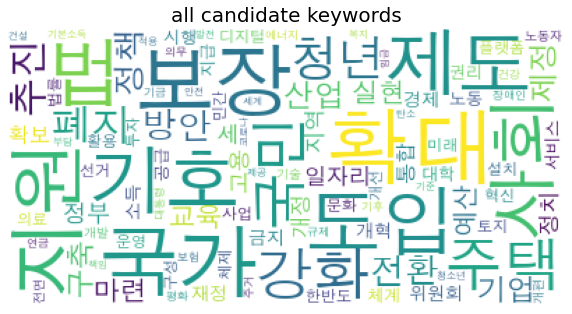

In [7]:
cl.showWordCloud(counts,'all candidate')

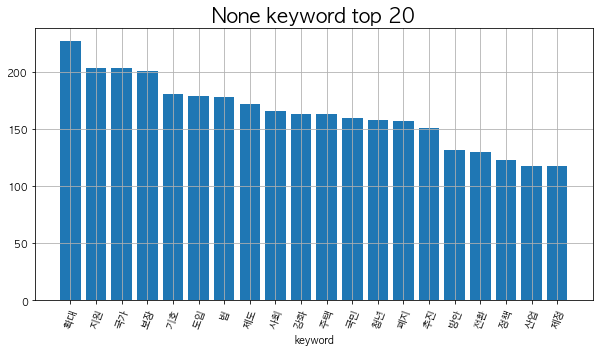

In [8]:
tags_20 = counts.most_common(20)
cl.showGraph(dict(tags_20))

In [18]:
# 기호 1번 샘플
clean_text_each = cl.dict_data(14,'each')
counts_each = [Counter(i) for i in clean_text_each]
counts_each[0]

cl.word_idx_dict_each(14)[0]

{'강화': 1,
 '확대': 2,
 '지원': 3,
 '추진': 4,
 '국가': 5,
 '제도': 6,
 '청년': 7,
 '구축': 8,
 '국민': 9,
 '전환': 10,
 '실현': 11,
 '보장': 12,
 '도입': 13,
 '산업': 14,
 '주택': 15,
 '지역': 16,
 '일자리': 17,
 '기호': 18,
 '사회': 19,
 '체계': 20,
 '개선': 21,
 '설치': 22,
 '법': 23,
 '공급': 24,
 '혁신': 25,
 '노동': 26,
 '아동': 27,
 '조성': 28,
 '체제': 29,
 '활성화': 30,
 '통합': 31,
 '위원회': 32,
 '투자': 33,
 '디지털': 34,
 '서비스': 35,
 '국비': 36,
 '보험': 37,
 '정책': 38,
 '방안': 39,
 '대응': 40,
 '경제': 41,
 '확보': 42,
 '안전': 43,
 '코로나': 44,
 '어르신': 45,
 '권리': 46,
 '고용': 47,
 '방비': 48,
 '교육': 49,
 '기본소득': 50,
 '피해': 51,
 '기술': 52,
 '확충': 53,
 '문화': 54,
 '활용': 55,
 '콘텐츠': 56,
 '지급': 57,
 '치료': 58,
 '과학기술': 59,
 '예산': 60,
 '재정': 61,
 '장애인': 62,
 '대통령': 63,
 '건강': 64,
 '부담': 65,
 '외교': 66,
 '책임': 67,
 '달성': 68,
 '대학': 69,
 '제정': 70,
 '범죄': 71,
 '건설': 72,
 '완화': 73,
 '사람': 74,
 '안심': 75,
 '안정': 76,
 '기본권': 77,
 '극복': 78,
 '협력': 79,
 '민간': 80,
 '청소년': 81,
 '기금': 82,
 '소득': 83,
 '균형발전': 84,
 '플랫폼': 85,
 '수당': 86,
 '마련': 87,
 '여성': 88,
 '달러': 89,
 '평화': 90,
 

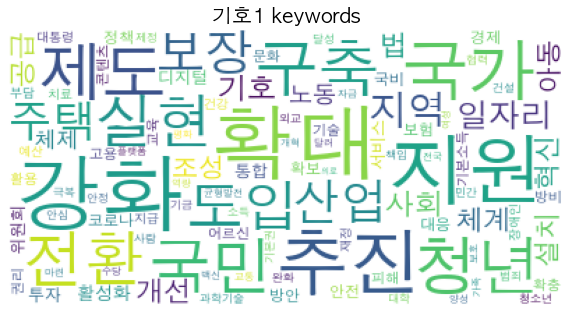

In [10]:
cl.showWordCloud(counts_each[0],'기호1')

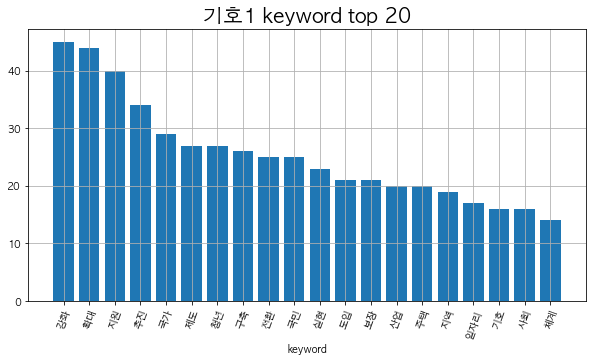

In [11]:
cl.showGraph(dict(counts_each[0].most_common(20)),'기호1')

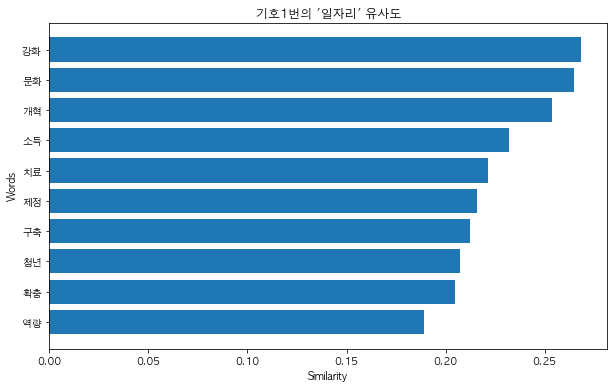

In [14]:
# 유사도 측정
# input : 번호,stopword path,
# drop_len=5 제거길이 (문장 정규표혀,공백 strip 후 빈문장 혹은 '목표','이행방법' 등의 문장 제거를 위한 단위길이)
path = '/Users/junho/Desktop/pycharmProjects/pythonProject/dacon/visualization/data/stopwords1.txt'
sents_clear = cl.make_clear_sentences(1,path,drop_len=5)
cl.show_simirality(sents_clear,'일자리','1')

In [15]:
# 모든 후보
path = '/Users/junho/Desktop/pycharmProjects/pythonProject/dacon/visualization/data/stopwords_all.txt'
temp_sents_all = [cl.make_clear_sentences(num,path)
                   for num in range(1,15)]
clear_sents_all = []
for i in temp_sents_all:
    clear_sents_all += i
model = Word2Vec(clear_sents_all)

In [16]:
# default topn = 10
model.wv.most_similar('부동산',topn=15)

[('지원', 0.9990044236183167),
 ('정부', 0.9989014267921448),
 ('정책', 0.998898983001709),
 ('국가', 0.9988625645637512),
 ('제도', 0.9988313317298889),
 ('산업', 0.998822808265686),
 ('교육', 0.9988018274307251),
 ('소득', 0.9987886548042297),
 ('사회', 0.9987797141075134),
 ('도입', 0.9987779855728149),
 ('고용', 0.9987713694572449),
 ('탄소', 0.9987702369689941),
 ('협력', 0.9987638592720032),
 ('세', 0.9987630844116211),
 ('지방', 0.9987618923187256)]

In [22]:
path = '/Users/junho/Desktop/pycharmProjects/pythonProject/dacon/visualization/data/promise10.csv'
df = pd.read_csv(path)
df


,Unnamed: 0,공약순위 1,공약순위 2,공약순위 3,공약순위 4,공약순위 5,공약순위 6,공약순위 7,공약순위 8,공약순위 9,공약순위 10
0,기호_1,코로나 팬데믹 완전극복과 피해소상공인에 대한 완전한 지원,"수출 1조 달러, 국민소득 5만 달러 달성, 주가지수 5000으로 세계5강 달성","경제적 기본권 보장, 여성안심 평등사회, ‘청년기회국가' 건설","311만호 주택공급으로 내집마련•주거안정 실현, 함께 잘 사는 균형발전","어르신, 환자, 장애인, 아동, 영•유아 돌봄 국가책임제, 국민안심국가 실현",일하는 사람들의 권리보장과 일자리 대전환으로 성장하는 사회 실현,"과학기술 5대 강국 실현과 미래인재 양성, 공교육 내실화를 위한 교육대전환",문화강국 실현과 미디어산업 혁신성장,"대통령 4년 중임제 개헌 추진, 국민 주권 실현을 위한 정치개혁과 사법개혁","스마트강군 건설, 실용외교로 평화보안 실현"
1,기호_2,코로나 극복 긴급구조및 포스트 코로나 플랜,지속가능한 좋은 일자리 창출,요에 부응하는 주택 250만호 이상 공급,스마트하고 공정하게 봉사하는 ‘디지털 플랫폼 정부’ 구현과 대통령실 개혁,과학기술 추격국가에서 원천기술 선도국가로,출산 준비부터 산후조리•양육까지 국가책임 강화,청년이 내일을 꿈꾸고 국민이 공감하는 공정한 사회 - 여성가족부 폐지,"당당한 외교, 튼튼한 안보",실현 가능한 탄소중립과 원전 최강국 건설,"공정한 교육과 미래인재 육성, 모두가 누리는 문화복지"
2,기호_3,기후위기 극복을 위한 정의로운 탈탄소사회로의 전환,"노동자, 자영업자, 농어민의 일할 권리와 기본권 보장","성차별, 폭력없는 성평등 사회 실현 청년, 청소년의 다양성 존중과 미래사회 보장",부동산 불평등 해소•투기 근절 기후위기•차별 해소를 위한 조세 개혁,"불공정 해소, 미래를 대비하는 경제개혁",국민건강권 및 전국민 돌봄 보장,"맞춤교육, 문화다양성, 표현의 자유가 보장되는 나라",모두가 존중받고 안전한 공동체,특권과 부패가 없는 정의로운 대한민국,평화와 공생의 한반도와 국제사회
3,기호_4,5•5•5 신성장전략으로 미래먹거리와 청년일자리 창출하겠습니다,자주•실용•평화 책임외교전략으로 한반도 평화통일 추진하겠습니다,"공적연금 통합하여 청년의 미래, 대한민국의 미래를 지키겠습니다",로나19 자영업 영업시간 제한 폐지하고 150조 손실보상하겠습니다.,반값 토지임대부 ‘안심주택’으로 내집마련 시대 열겠습니다,부모찬스 수시 폐지하고 학제개편으로 창의적 미래교육 하겠습니다,강성 귀족노조 혁파하고 공정 시장경제 확립하겠습니다,생애주기별 안심복지로 요람에서 무덤까지 국가가 책임지겠습니다,책임총리 - 책임장관제로 제왕적 청와대정부 혁신하겠습니다,"기후위기시대 탄소중립 추진하고, 스마트 농어촌으로 식량주권 지키겠습니다."
4,기호_5,당신이 누구든매달 65만 원 기본소득,토지세 기본소득 패키지로 부동산 불평등 해소,누구나 나답게 사는 성평등 사회,민주주의 기본소득으로 시작하는 정치개혁,기본소득 그린뉴딜로 2050 탄소 중립 달성,공공사회서비스 강화로 모두의 기본권이 보장되는 나라,공정한 디지털 혁신을 위한 기본 소득 디지털뉴딜,디지털 전환에 발맞춘 사각지대 없는노동권 보장,생태 위기를 극복하는 모두를 위한공존 사회,국민을 위한 재정•통화제도 민주화
5,기호_6,코로나 긴급생계지원금 1억 지급 및 국민배당금 매월 150만원 평생 지금,"결혼하는 부부에게 3억원 지급, 출산수당 5천만원, 육아수당 매월 100만원 지급,...","국회의원 100명으로 축소, 무보수 명예직으로 전환(지자체 의원 포함),지방 자치단...","징병제를 폐지 모병제로 전환하고, 기존 사병월급 매월 200만 원으로 상향 지급, ...","중, 고증 전공 1과목만 시험 그 총점으로 대학 진학","청년취업 국가책임제 실시, 중소기업 취업자에게 월 100만원 지급, 중소기업 5년 ...","양도소득세, 상속세, 부동산 및 자동차 보유세 폐지, 증권거래세, 갑근세 폐지, 김...",용산 미군기지와 성남 서울공항 부지에 100만호의 신혼부부 주택 건설 무상 공급,"반려동물 무료진료카드, 안경무료 카드, 청소년안심식사카드 무료 제공","한반도 외곽 순환도로, 수도권 순환 고속전철 건설 및 BV벨트인(부산-블라디보스톡..."
6,기호_7,재벌국유화•국가투자은행설립으로 공공경제 실현,"1,000만 국가책임일자리로완전 고용",전 기업 탄소배출 감축의 무제로 기후정의 실현,읍면동 공공가사돌봄센터로 국가 책임 돌봄사회,"민간임대 금지•공공주택 1,000만 호로 공공주거 실현",의료•교육•교통•통신•에너지 공영화로 공공복지 실현,"여성차별•폭력• 없는 사회, 성•재생산권리 보장",차별금지법 제정으로 차별과 배제 없는 평등사회,"한반도 평화조약 체결, 한반도 비핵지대화","정당법 폐지, 교사•공무원의 정치 활동 보장"
7,기호_8,4•15 부정선거 진실 규명,공직선거 및 정당 내 전자투표금지,선관위 법관 임명 금지,투표절차의 공정성 확보,자선거인명부 사용 금지,"사전투표 폐지, 우편투표 최소화",재외국인 현장 투표/현장 개표,탄핵 재조명하겠습니다,방역의 허구성 재조명,정권을 심판하겠습니다
8,기호_9,권력구조 개편 및 정치 개혁,공공부문•관료 개혁,국가균형발전,소상공인•자영업자 및 중소기업 대책,보편적 소득안전망•저출산고령화 대책,G10 대한민국 만들기,1가구 1주택 꿈 이루기,교육개혁,청년 5대 권리장전,선진과학기술•4차산업혁명 대책
9,기호_10,한•미•일 군사동맹강화와 한•일 핵무기 공동개발,공영방송 폐지와 빅테크 언론검열 금지,"법원 내 사조직 폐지, 사전선거 폐지, 수개표 실시",대규모 재개발을 통한 풍부한 민간주택공급,대학의 완전 자유화 보장과 사학재단 자율 정리,연금개혁,신혼부부 주택구입에 95% 정부지불보증,박근혜 대통령 재심을 통한 거짓 세력의 응징과 적폐수사로 수감된 인사들의석방과 사면,5•18 역사왜곡처벌법(5•18민주화운동특별법) 폐지와 5•18유공자 공개,"중대재해처벌법 폐지와 노동이사제 도입 반대, 탈원전 정책 폐기"
